<a href="https://colab.research.google.com/github/leinaxd/NOTES/blob/main/digital_image_processing/notebooks/13_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMAGE SEGMENTATION
```
Author: Eichenbaum Daniel
Email: eichenbaum.daniel@gmail.com
```

This is a practical demo to understand the theory behind:
  ```
DIP Lecture 12a: Image Segmentation ¬Rich Radke
    https://www.youtube.com/watch?v=ZF-3aORwEc0&list=PLuh62Q4Sv7BUf60vkjePfcOQc8sHxmnDX&index=14

Textbook: 10.4-10.6 Digital Image Processing
  Gonzalez and Woods, 4th ed.  
  https://www.amazon.com/-/es/Rafael-Gonzalez/dp/0133356728  
  ```

In this exercize we analyze an X-Ray image of a weld containing several cracks and porosities, we ilustrate the use of region growing by segmenting the defective weld regions. These regions could be used in applications such as weld inspection, historical studies or for controlling an automated welding system.

(333, 500, 3)


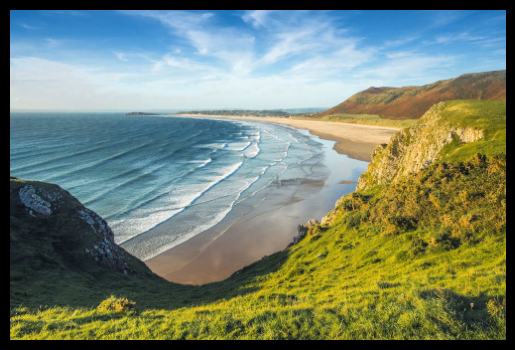

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import urllib.request
import cv2
import sklearn as sk
import skimage as ski

plt.style.use('dark_background')

url = "https://github.com/leinaxd/NOTES/raw/main/digital_image_processing/img/coast.jpg" #@param ["https://github.com/leinaxd/NOTES/raw/main/digital_image_processing/Lecture%2013/weld_defect.jpg", "https://github.com/leinaxd/NOTES/raw/main/digital_image_processing/img/coast.jpg"]
with urllib.request.urlopen(url) as url:
    img = plt.imread(url, format='jpg')
plt.imshow(img)
plt.axis('off')

print(img.shape)

r_mask = img[:, :, 0]
g_mask = img[:, :, 1]
b_mask = img[:, :, 2]

#turn image to gray
g_img = r_mask*0.2989 + g_mask*0.5870 + b_mask*0.1140
u_img = np.uint8(g_img)

Let
- I(x,y) denote an input image
- S(x,y) denote a  seed array containing 1s at the locations of seeds points 0s otherwise.
- Q denote a predicate to be applied at each location (x,y).

Then a basic **Region Growingn algorithm** based on 8-conectivity may be stated as follows.

1. Find all connected components in S(x,y) and reduce each connected component to one pixel; Label all such pixels found as 1. All other pixels are labeled 0.

2. Form an image $f_Q$ such that, at each point $(x,y)$, $f_Q(x,y)=1$ if the input image satisfies a given predicate $Q$, at those coordinates, and $f_Q(x,y)=0$ otherwise.

3. Let $g$ be an image formed by appending to each seed point in $S$ all the 1-valued points in $f_Q$ that are 8-connected to that seed point.

4. Label each connected component in $g$ with a different region label (e.g. integers or letters). This is the segmented image obtained by region growing.

In [ ]:
from operator import rshift
fig, ax = plt.subplots(2,3, figsize=(15,10))

ax[0][0].imshow(g_img, cmap='gray')
ax[0][0].axis('off')
ax[0][0].set_title('original = I(x,y)');

#@markdown 1. Determine the seed points by thresholding the image
nbins=150 #@param {'type':'integer'}
th = 50 #@param {'type':'integer'}
ax[0][1].hist(g_img.flatten(), bins=nbins, density=True);
ax[0][1].axvline(th, color='r')
ax[0][1].set_xlim([0, 255]);
im_1 = (g_img <= th)
im_1 = np.uint8(im_1)
f_im_1 = im_1.flatten()
ax[0][2].imshow(im_1, cmap='gray')
ax[0][2].set_title(f'Foreground');

#@markdown 2. Preprocessing
cut_edge_at = 36 #@param {'type':'integer'}
ax[0][2].axhline(cut_edge_at, color='r')
ax[0][2].axhline(im_1.shape[0]-cut_edge_at, color='r')

im_2 = im_1.copy()
im_2[:cut_edge_at, :] = 0
im_2[-cut_edge_at:, :] = 0
ax[1][0].imshow(im_2, cmap='gray')
ax[1][0].set_title(f'No edges');
ax[1][0].axis('off');

eroded_size = 1 #@param {'type':'integer'}
kernel = np.ones((eroded_size,eroded_size), np.uint8)
im_3 = cv2.erode(im_2, kernel)
ax[1][1].imshow(im_3, cmap='gray')
ax[1][1].set_title(f'Eroded by {eroded_size} = S(x,y)');
ax[1][1].axis('off');

#@markdown 3. Define the predicate $Q=\{True\ if\ |S_8(x,y) - I(x,y)|\le T$
T = 24 #@param {'type':'integer'}
nIter = 20 #@param {'type':'integer'}

R,C = g_img.shape
im_4 = np.zeros_like(g_img)
kernel = np.ones((3,3),np.uint8)

for r in range(R):
    for c in range(C):
        if im_3[r,c] == 0: continue
        #Grow the seed
        similar_img = np.uint8(np.abs(g_img - g_img[r,c]) <= T) #all points similar in intensity

        S_8 = im_3.copy()
        for i in range(nIter):
            S_8 = cv2.dilate(S_8, kernel,iterations=1) #Is it connected?
            S_8 = S_8 * similar_img

        im_4 += S_8 #apply mask for similarity and connectivity

im_4 = (im_4>0)*g_img
ax[1][2].imshow(im_4, cmap='gray')
ax[1][2].set_title(f'Thresholded by {T} respect to S(x,y)');
ax[1][2].axis('off');

Region Spli and Merge

The procedure just discussed grows regions from seeds points. An alternative is to subdivide an image initially into a set of dijoints regions and then merge and/or split the regions in an attempt to satisfy the conditions of segmentation.


Let R represent the entire image region and select a predicate Q.
1. Split into four dijoint quadrants any region $R_i$ for which $Q(R_i)=True$
2. When no further splitting is possible, merge any adjacent regions $R_j$ and $R_k$ for which $Q(R_j \cap R_k)=True $
3. Stop when no further merging is possible.

In [ ]:
R = np.array(
    [[ 1, 2, 3, 4, 5, 6],
     [10,20,30,40,50,60],
     [100,200,300,400,500,600],
     [600, 500, 400, 300, 200,100]
     ])

def Q(img, a,b):
    return np.mean(img)>200
# For testing

In [ ]:

#Step 1. Define Q
a = 49 #@param
b = 134 #@param
def Q1 (img, a, b):
    std_R = np.std(img)
    return True if std_R < a else False

def Q2 (img, a, b):
    mu_R = np.mean(img)
    return True if mu_R<b else False

def Q3 (img, a, b):
    std_R = np.std(img)
    mu_R = np.mean(img)
    return True if std_R < a and mu_R<b else False
#Step 2. Select a region
R = g_img.copy()


#Step 4. Compute if the Region approves
def recursive_split(R, Q):
    mask = np.zeros_like(R)
    if Q(R, a, b): return mask+1
    if R.shape[0] <= 1 or R.shape[1]<=1: return mask
    #Step 5. Split
    Sx, Sy = R.shape
    rs = 0
    re = rs+Sx
    cs = 0
    ce = cs + Sy
    #Step 6. Split and Merge
    mask[rs:re//2, cs:ce//2] = recursive_split(R[rs:re//2, cs:ce//2],Q)
    mask[re//2:re, ce//2:ce] = recursive_split(R[re//2:re, ce//2:ce],Q)
    mask[rs:re//2, cs:ce//2] = recursive_split(R[rs:re//2, cs:ce//2],Q)
    mask[re//2:re, cs//2:ce] = recursive_split(R[re//2:re, cs//2:ce],Q)

    return mask

fig, ax = plt.subplots(3,3,figsize=(15,15))

print(f"mean: {np.mean(R)}, std:{np.std(R)}")
ax[0][0].imshow(R, cmap='gray')
ax[0][0].axis('off');
ax[1][0].imshow(R, cmap='gray')
ax[1][0].axis('off');
ax[2][0].imshow(R, cmap='gray')
ax[2][0].axis('off');

new_img = recursive_split(R, Q1)
ax[0][1].imshow(new_img, cmap='gray')
ax[0][1].axis('off');
ax[0][1].set_title(f"a:{a} > std")
ax[0][2].imshow(new_img*R, cmap='gray')
ax[0][2].axis('off');

new_img = recursive_split(R, Q2)
ax[1][1].imshow(new_img, cmap='gray')
ax[1][1].axis('off');
ax[1][1].set_title(f"b:{b} > mu")
ax[1][2].imshow(new_img*R, cmap='gray')
ax[1][2].axis('off');

new_img = recursive_split(R, Q3)
ax[2][1].imshow(new_img, cmap='gray')
ax[2][1].axis('off');
ax[2][1].set_title(f"b:{b} > mu and a:{a} > std")
ax[2][2].imshow(new_img*R, cmap='gray')
ax[2][2].axis('off');


K-means clustering

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

K=5 #@param {'type':'integer'}
n_samples = 300

# Generate Random Samples (x1, y1) ... (xn, yn)
X, _ = sk.datasets.make_blobs(n_samples=300, centers=K, random_state=42)

# Apply K-means
kmeans = sk.cluster.KMeans(n_clusters=K, random_state=42, n_init=1)
labels = kmeans.fit_predict(X)
mu = kmeans.cluster_centers_

# Visualizing results
fig, ax = plt.subplots(3,2)

ax[0][0].scatter(X[:, 0], X[:, 1], edgecolors='k')
ax[0][0].set_title('DATA')
ax[0][0].axis('off')

ax[0][1].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', edgecolors='k')
ax[0][1].scatter(mu[:, 0], mu[:, 1], c='red', marker='X', s=200, label='Centroids')
ax[0][1].set_title('K-means Clustering')
ax[0][1].legend()
ax[0][1].axis('off')


ax[1][0].imshow(img)
ax[1][0].axis('off')

#@markdown **NOTE**

#@markdown Each pixel (R,G,B) is a K-means sample.

#@markdown location doesn't matter, so image is flatten and reshaped

r,c,ch = img.shape
f_img = img.reshape(r*c, ch) #flattens image so each pixel is a sample.
kmeans = sk.cluster.KMeans(n_clusters=K, n_init=1)
labels = kmeans.fit_predict(f_img)
mu = kmeans.cluster_centers_
mu = np.uint8(mu)

k_img = labels.reshape(r,c)
k_img = mu[k_img] #SWAP THE LABEL CLASS FOR THE CENTROID COLOR

ax[1][1].imshow(k_img)
ax[1][1].axis('off')

lab_img = ski.color.rgb2lab(k_img/255.0)
l_component = lab_img[:, :, 0].copy()
a_component = lab_img[:, :, 1]
b_component = lab_img[:, :, 2]

lab_img[:,:,0]=0 # No L-component
f_img = lab_img.reshape((-1, 3)) #flattens image so each pixel is a sample.
kmeans = sk.cluster.KMeans(n_clusters=K, n_init=1)
labels = kmeans.fit_predict(f_img)
mu = kmeans.cluster_centers_
k_ab_img = mu[labels]
k_ab_img = k_ab_img.reshape(img.shape)

k_ab_img[:,:,0]=l_component #Restore L-component
k_ab_img = ski.color.lab2rgb(k_ab_img) #INVERSE TRANSFORM
k_ab_img = np.uint8(k_ab_img*255)
lab_img = np.uint8(lab_img)
ax[2][0].imshow(b_component, cmap='gray')
ax[2][0].set_title('b component')
ax[2][0].axis('off')
ax[2][1].imshow(k_ab_img)
ax[2][1].axis('off')
ax[2][1].set_title('kmeans in ab space')
pass

In [ ]:
#@markdown **TEST IMG**

#@markdown L A* B* space

def create_interpolated_matrix(height=5, width=5, color_ul=(255, 0, 0), color_ur=(0, 0, 255),
                               color_br=(0, 255, 0), color_bl=(255, 255, 0)):
    rows = np.linspace(color_ul, color_bl, height, dtype=np.uint8)
    cols = np.linspace(color_ur, color_br, width, dtype=np.uint8)

    matrix = np.zeros((height, width, 3), dtype=np.uint8)

    for i in range(height):
        for j in range(width):
            ratio_r = i / (height - 1)
            ratio_c = j / (width - 1)

            top_color = tuple(int(c1 * (1 - ratio_r) + c2 * ratio_r) for c1, c2 in zip(color_ul, color_bl))
            bottom_color = tuple(int(c1 * (1 - ratio_r) + c2 * ratio_r) for c1, c2 in zip(color_ur, color_br))
            matrix[i, j] = tuple(int(c1 * (1 - ratio_c) + c2 * ratio_c) for c1, c2 in zip(top_color, bottom_color))

    return matrix

test_img = create_interpolated_matrix(15,15)



lab_img = ski.color.rgb2lab(test_img)
l_component = lab_img[:, :, 0]
a_component = lab_img[:, :, 1]
b_component = lab_img[:, :, 2]

fig, ax = plt.subplots(3,4)

ax[0][0].imshow(test_img)
ax[0][0].set_title('original')
ax[0][0].axis('off')
ax[0][1].scatter(a_component, b_component, c=test_img.reshape((-1, 3))/255.0, marker='.')
ax[0][1].set_title('AB space')
ax[0][1].set_xlabel('A')
ax[0][1].set_ylabel('B')

r_img = np.rot90(test_img)
lab_img = ski.color.rgb2lab(r_img)
l_component = lab_img[:, :, 0]
a_component = lab_img[:, :, 1]
b_component = lab_img[:, :, 2]
ax[1][0].imshow(r_img)
ax[1][0].set_title('rotated image')
ax[1][0].axis('off')
ax[1][1].scatter(a_component, b_component, c=r_img.reshape((-1, 3))/255.0, marker='.')
ax[1][1].axis('off')

i_img = np.flipud(test_img)
i_img = np.fliplr(i_img)

lab_img = ski.color.rgb2lab(i_img)
l_component = lab_img[:, :, 0]
a_component = lab_img[:, :, 1]
b_component = lab_img[:, :, 2]
ax[2][0].imshow(i_img)
ax[2][0].set_title('inverted image')
ax[2][0].axis('off')
ax[2][1].scatter(a_component, b_component, c=i_img.reshape((-1, 3))/255.0, marker='.')
ax[2][1].axis('off');

test_img = create_interpolated_matrix(15,15, color_bl=(0,0,0))
lab_img = ski.color.rgb2lab(test_img)
l_component = lab_img[:, :, 0]
a_component = lab_img[:, :, 1]
b_component = lab_img[:, :, 2]
ax[0][2].imshow(test_img)
ax[0][2].set_title('with black')
ax[0][2].axis('off')
ax[0][3].scatter(a_component, b_component, c=test_img.reshape((-1, 3))/255.0, marker='.')
ax[0][3].axis('off');

test_img = create_interpolated_matrix(15,15, color_ul=(0,255,255), color_ur=(255,0,255),color_bl=(255,255,0), color_br=(0,0,0))
lab_img = ski.color.rgb2lab(test_img)
l_component = lab_img[:, :, 0]
a_component = lab_img[:, :, 1]
b_component = lab_img[:, :, 2]
ax[1][2].imshow(test_img)
ax[1][2].set_title('CMYK')
ax[1][2].axis('off')
ax[1][3].scatter(a_component, b_component, c=test_img.reshape((-1, 3))/255.0, marker='.')
ax[1][3].axis('off');

height, width =128,128
test_img = np.random.randint(0, 256, size=(height, width, 3), dtype=np.uint8)
lab_img = ski.color.rgb2lab(test_img)
l_component = lab_img[:, :, 0]
a_component = lab_img[:, :, 1]
b_component = lab_img[:, :, 2]
ax[2][2].imshow(test_img)
ax[2][2].set_title('random')
ax[2][2].axis('off')
ax[2][3].scatter(a_component, b_component, c=test_img.reshape((-1, 3))/255.0, marker='.')
ax[2][3].axis('off');

fig = plt.figure(figsize=(8, 6))
gs = matplotlib.gridspec.GridSpec(4, 2, width_ratios=[1, 2])

lab_img = ski.color.rgb2lab(img)
l_component = lab_img[:, :, 0]
a_component = lab_img[:, :, 1]
b_component = lab_img[:, :, 2]

# plt.tight_layout()

ax1 = plt.subplot(gs[0, 0])
ax1.imshow(img)
ax1.set_title('original')
ax1.axis('off')


ax2 = plt.subplot(gs[1, 0])
ax2.imshow(l_component, cmap='gray')
ax2.set_title('L-component')
ax2.axis('off')

ax3 = plt.subplot(gs[2, 0])
ax3.imshow(a_component, cmap='gray')
ax3.set_title('A-component')
ax3.axis('off')

ax4 = plt.subplot(gs[3, 0])
ax4.imshow(b_component, cmap='gray')
ax4.set_title('b-component')
ax4.axis('off')

ax5 = plt.subplot(gs[:, 1])
ax5.set_title('AB space')
ax5.scatter(a_component, b_component, c=img.reshape((-1, 3))/255.0, marker='.')
ax5.set_xlabel('A')
ax5.set_ylabel('B');

## SLIC, SUPERPIXEL CLUSTERING (SIMPLE, LINEAR, ITERATIVE CLUSTERING)

In [ ]:

num_segments = 1000 #@param {'type':'integer'}
compactness = 10 #@param {'type':'integer'}
kind = 'avg' #@param ['avg', 'overlay']
# Image of labels
segments = ski.segmentation.slic(img, n_segments=num_segments, compactness=compactness)

overlapping = img if kind == 'avg' else None
# Applies a mask to the img
segmentation = ski.color.label2rgb(segments, image=overlapping, kind=kind)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(segments)
plt.title('Segments labels')
plt.axis('off');

plt.subplot(1, 3, 3)
plt.imshow(segmentation)
plt.title('Segmented Image')
plt.axis('off');

# Applied for second time
img_2 = segmentation
segments = ski.segmentation.slic(img_2, n_segments=num_segments, compactness=compactness)
overlapping = img_2 if kind == 'avg' else None
segmentation = ski.color.label2rgb(segments, image=overlapping, kind=kind)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(img_2)
plt.title('segmentation applied')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(segments)
plt.title('2x Segments labels')
plt.axis('off');

plt.subplot(1, 3, 3)
plt.imshow(segmentation)
plt.title('2x Segmented Image')
plt.axis('off');
print("Re appling 2x times the same clustering converges to the same outcome")

GRAPH CUT (lazzy snapping)

The idea is to connect each pixel to a Foreground Terminal Node or a Background one. You start with all connected and step by step you get cutting through a weight function

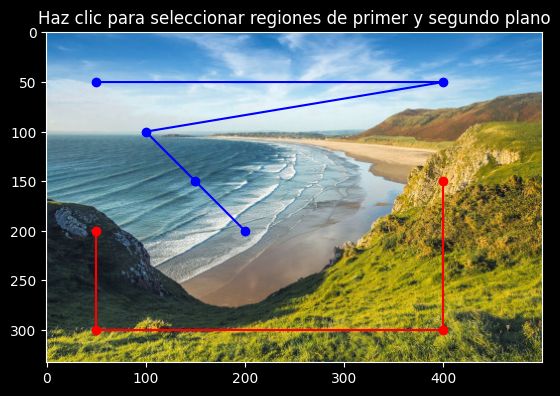

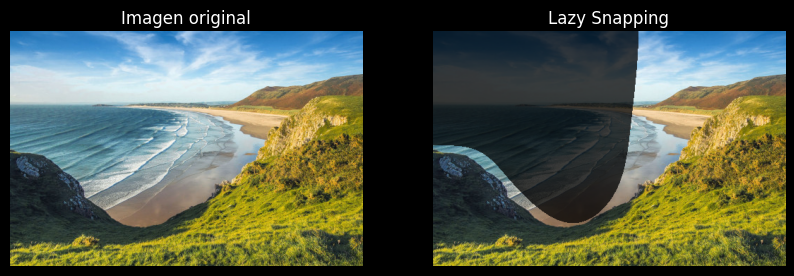

In [17]:
# Seleccionar regiones de primer y segundo plano
scribbles_foreground = [[50, 200], [50, 300], [400, 300], [400, 150]] #@param
scribbles_background = [[50, 50], [400, 50],[100, 100], [150, 150], [200, 200]] #@param

scribbles_foreground = np.array(scribbles_foreground)
scribbles_background = np.array(scribbles_background)

# Aplicar Lazy Snapping
labels = np.zeros(img.shape, dtype=np.uint8)
labels[scribbles_foreground[:,1], scribbles_foreground[:,0]] = 1
labels[scribbles_background[:,1], scribbles_background[:,1]] = 2

labels = ski.segmentation.random_walker(img, labels, beta=10, mode='bf')



# Visualizar el resultado
plt.imshow(img)
plt.title("Haz clic para seleccionar regiones de primer y segundo plano")
plt.plot(scribbles_foreground[:,0],scribbles_foreground[:,1], 'r-o')
plt.plot(scribbles_background[:,0],scribbles_background[:,1], 'b-o')

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Imagen original')

new_img = img.copy()
new_img[labels==2] //= 4
ax[1].imshow(new_img, cmap='viridis')
ax[1].set_title('Lazy Snapping')

for a in ax:
    a.axis('off')


In [ ]:
# Obtener el grafo de la imagen
g = ski.future.graph.rag_mean_color(img, labels)

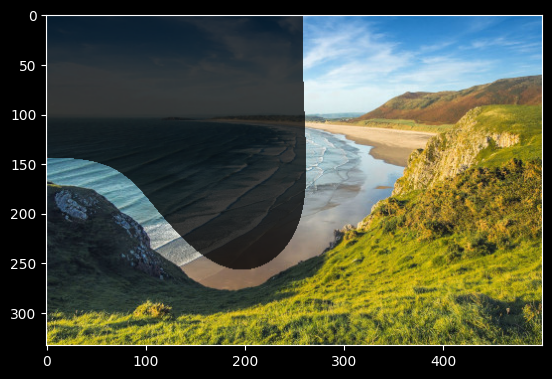

In [14]:
new_img = img.copy()
new_img[labels==2] //= 4
plt.imshow(new_img)